In [80]:
import dbcollection as dbc
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
mpii_pose = dbc.load('mpii_pose')

==> Dataset 'mpii_pose' not found in cache.
Proceeding to download the data files...
==> Download mpii_pose data to disk...
Creating save directory in disk: /home/furiousteabag/dbcollection/downloads/mpii_pose
Creating save directory in disk: /home/furiousteabag/dbcollection/mpii_pose


100% (11805608 of 11805608) |############| Elapsed Time: 0:04:29 Time:  0:04:29


patool: Extracting /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1.tar.gz ...
patool: running /bin/tar --extract -z --file /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1.tar.gz --directory /home/furiousteabag/dbcollection/downloads/mpii_pose
patool: ... /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1.tar.gz extracted to `/home/furiousteabag/dbcollection/downloads/mpii_pose'.


100% (12051 of 12051) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


patool: Extracting /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1_u12_2.zip ...
patool: ... /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1_u12_2.zip extracted to `/home/furiousteabag/dbcollection/downloads/mpii_pose'.
==> Dataset download complete.
==> Updating the cache manager
==> Processed metadata not found for dataset 'mpii_pose', task 'keypoints'.
Proceeding to process the metadata for this task...
==> Setup directories to store the data files.
==> Process 'mpii_pose' metadata to disk...

Processing 'keypoints' task:

==> Storing metadata to file: /home/furiousteabag/dbcollection/mpii_pose/keypoint.h5

==> Loading data annotations from disk... Done.

Saving set metadata: train

==> Setting up the data fields:
> Processing 'image_filenames' metadata... Done.
> Processing 'scale' metadata... Done.
> Processing 'objpos' metadata... Done.
> Processing 'video_ids' metadata... Done.
> Processing 'video_names' metadata... Done.
> Process

In [3]:
mpii_pose

DataLoader: mpii_pose ('keypoints' task)

In [3]:
data = pd.read_csv('../data/kaggle_mpii/mpii_human_pose.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17372 entries, 0 to 17371
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            17372 non-null  int64  
 1   NAME          17372 non-null  object 
 2   r ankle_X     17372 non-null  int64  
 3   r ankle_Y     17372 non-null  int64  
 4   r knee_X      17372 non-null  int64  
 5   r knee_Y      17372 non-null  int64  
 6   r hip_X       17372 non-null  int64  
 7   r hip_Y       17372 non-null  int64  
 8   l hip_X       17372 non-null  int64  
 9   l hip_Y       17372 non-null  int64  
 10  l knee_X      17372 non-null  int64  
 11  l knee_Y      17372 non-null  int64  
 12  l ankle_X     17372 non-null  int64  
 13  l ankle_Y     17372 non-null  int64  
 14  pelvis_X      17372 non-null  int64  
 15  pelvis_Y      17372 non-null  int64  
 16  thorax_X      17372 non-null  int64  
 17  thorax_Y      17372 non-null  int64  
 18  upper neck_X  17372 non-nu

In [62]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        #plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Counts')
        #plt.xticks(rotation = 90)
        plt.title('MPII Human Pose Categories')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.savefig('../imgs/mpii_cats.png')
    plt.show()

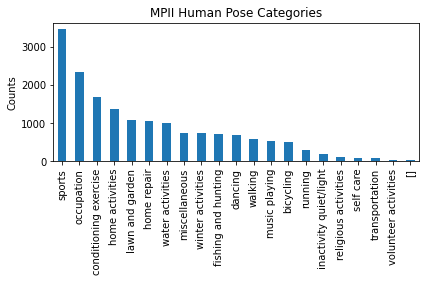

In [63]:
plotPerColumnDistribution(data, 10, 5)

In [30]:
len(data.loc[(data['Activity'].str.contains('sleeping'))])

12

In [64]:
cats = set(list(data['Category']))
print(cats)

{'volunteer activities', 'sports', 'walking', 'music playing', 'miscellaneous', 'winter activities', 'conditioning exercise', 'inactivity quiet/light', 'dancing', 'bicycling', 'running', 'religious activities', 'transportation', 'home repair', 'occupation', 'home activities', 'water activities', 'lawn and garden', 'fishing and hunting', 'self care', '[]'}


In [32]:
with open('../data/mpii_anns/mpii_trainval.json') as f:
    mpii_data = json.load(f)

In [33]:
len(mpii_data)

29116

In [34]:
my_mpii = []

In [35]:
good_cats = ['running', 'dancing', 'bicycling', 'walking', 'fishing and hunting']

In [36]:
good_acts = ['standing', 'sitting', 'skiing', 'swimming', 'cooking', 
             'driving', 'rock climbing', 'horseback', 'skateboarding',
             'yoga', 'canoe', 'training', 'lying']

In [37]:
len(good_cats) + len(good_acts) + 1

19

In [38]:
for i in mpii_data:
    name = i['image']
    cat = data.loc[data['NAME'] == name]['Category'].values
    act = data.loc[data['NAME'] == name]['Activity'].values
    if len(cat) > 0:
        if (cat[0] in good_cats):
            i['category'] = cat[0]
            my_mpii.append(i)
        elif (cat[0] == 'sports' and bool(re.search('\wball', act[0]))):
            i['category'] = 'sport with ball'
            my_mpii.append(i)
        else:
            for good_act in good_acts:
                if good_act in act[0]:
                    i['category'] = good_act
                    my_mpii.append(i)

In [326]:
with open('../data/mpii.json', 'w') as f:
    json.dump(my_mpii, f)

In [55]:
cats = ['running', 'dancing', 'bicycling', 'walking', 'fishing and hunting', 'sport with ball',
                           'standing', 'sitting', 'skiing', 'swimming', 'cooking', 'driving', 'rock climbing', 
                           'horseback', 'skateboarding', 'yoga', 'canoe', 'training', 'lying']

In [104]:
two_cats_mpii = []

In [105]:
two_acts = ['standing', 'sitting']

for i in mpii_data:
    name = i['image']
    cat = data.loc[data['NAME'] == name]['Category'].values
    act = data.loc[data['NAME'] == name]['Activity'].values
    if len(cat) > 0:
        for act_ in two_acts:
                if act_ in act[0]:
                    i['category'] = act_
                    two_cats_mpii.append(i)

In [106]:
len(two_cats_mpii)

3796

In [107]:
with open('../data/mpii2cats.json', 'w') as f:
    json.dump(two_cats_mpii, f)

In [56]:
df = pd.read_json('../data/mpii.json')

Text(0.5, 1.0, 'My Categories')

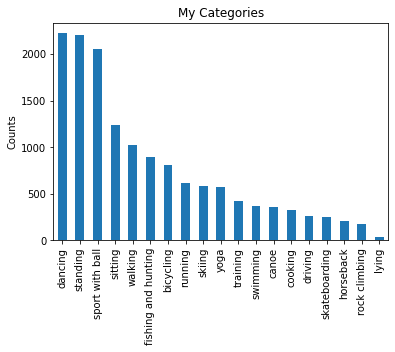

In [60]:
plot = df['category'].value_counts().plot(kind='bar');
plot.set_ylabel('Counts')
plot.set_title('My Categories')

In [89]:
j = df[df['category'] == 'sitting'].iloc[[2]]['joints'].values

In [61]:
fig = plot.get_figure()

fig.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
fig.savefig('../imgs/my_cats.png')

In [331]:
import torch

In [360]:
target = torch.randint(0, 19, (19,))
one_hot = torch.nn.functional.one_hot(torch.arange(0, 19))

In [537]:
j = my_mpii[12110]

In [538]:
j = j['joints']

In [540]:
j = [[y/256 for y in x] for x in j]

In [81]:
def draw_keypoints(kps, verbose=False):
    lines = [(0,1),(1,2),(2,6),(6,3),(3,4),(4,5),(6,7),(7,8),(8,9),(10,11),(11,12),(12,7),(7,13),(13,14),(14,15)]
    pose_dict = {0: 'right_ankle',
        1: 'right_knee',
        2: 'right_hip',
        3: 'left_hip',
        4: 'left_knee',
        5: 'left_ankle',
        6: 'pelvis',
        7: 'thorax',
        8: 'upper_neck',
        9: 'head_top',
        10: 'right_wrist',
        11: 'right_elbow',
        12: 'right_shoulder',
        13: 'left_shoulder',
        14: 'left_elbow',
        15: 'left_wrist'}

    joints = []
    for i in range(len(kps)):
        joint = kps[i]
        joint_x = joint[0]*(-1)
        joint_y = joint[1]*(-1)
        #if (joint_x > 0):
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o', label=i)
        if (verbose):
            plt.annotate(pose_dict[i], (joint_x, joint_y))
        
    for l in lines:
        j1 = kps[l[0]]
        j2 = kps[l[1]]
        #if (j1[0] > 0 and j2[0] > 0):
        x = [j1[0]*(-1), j2[0]*(-1)]
        y = [j1[1]*(-1), j2[1]*(-1)]
        plt.plot(x, y)
    plt.show()

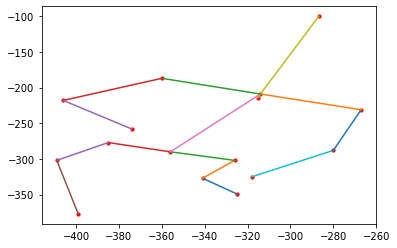

In [93]:
draw_keypoints(j[0])